In [1]:
import psycopg2, config
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter
import seaborn as sns

from datetime import date

In [2]:
def executeMining():
    
    # In[2]:
    # Connexion à la BDD PG bdd_scantonnet et requêtage
    
    conn = psycopg2.connect(database="bdd_scantonnet", user=config.user,password=config.password, host='127.0.0.1') 
    
    sql = """select jokes from "chuckJokes";"""
    df = pd.read_sql_query(sql, conn)
    
    # In[3]:
    # Tokenisation et traitement préalable de la liste des mots de chaque blague
    
    # On stocke toutes les blagues du df dans une string
    text = ""
    for comment in df.jokes : 
        text+=comment
        text+=" "
        
    text = text.lower()
    
    # On définit la liste des stopwords (à ne pas prendre en compte)
    stop_words = set(stopwords.words('english'))
    addingStopWordsList = [",", ".","'","n't","'s","to","of",'and',"with","was","?","!",'``',"...","''"]
    for mot in addingStopWordsList:
        stop_words.add(mot)
        
    # On fait une liste qui sépare chacun des mots de la string text et exclue les stopwords
    
    text_tokenized = word_tokenize(text, language='english')
    
    tokens = []
    for mot in text_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    
    # In[4]:
    # Création du nuage de mots suivant une image
    
    def plot_word_cloud(txt, masque, background_color = "black") :
        # Définir un masque
        # mask_coloring = np.array(Image.open(str(masque)))
        # from wordcloud import ImageColorGenerator
        mask = np.array(Image.open(masque))
        # img_color = ImageColorGenerator(mask)
        
        # Définir le calque du nuage des mots
        wc = WordCloud(mask=mask, random_state=42, collocations=False,
                  width=400, height=200, margin=2,
                  ranks_only=None, prefer_horizontal=0.9,
                  scale=1, color_func=None,
                  max_words=1000,
                  min_font_size=4, stopwords=stop_words,
                  background_color='black',
                  max_font_size=90, font_step=1, mode='RGB',
                  relative_scaling=0.5, regexp=None, colormap=None, normalize_plurals=True)
        
        plt.figure(figsize= (15,10)) # Initialisation d'une figure
        wc.generate(txt)           # "Calcul" du wordcloud
        plt.imshow(wc) # Affichage
        plt.show()
      
    plot_word_cloud(text, "chuck2.jpg")
    
    # # Code d'affichage du masque
    # import matplotlib.image as mpimg
    # img = mpimg.imread("chuck2.jpg")
    # plt.imshow(img)
    # plt.show()
    
    # In[5]:
    # Bar graphs des 15 mots les plus utilisés (avec et sans Chuck Norris)
    dico = Counter(tokens)
    dico.most_common(17)
    
    mots = [m[0] for m in dico.most_common(15)]
    freq = [m[1] for m in dico.most_common(15)]
    
    plt.figure(figsize= (15,10))
    sns.barplot(x=mots, y=freq)
    plt.title('15 mots les plus fréquemment employés')
    
    #On retire les mots "Chuck" et "Norris" de la liste
    
    dico.pop("chuck")
    dico.pop("norris")
    mots = [m[0] for m in dico.most_common(15)]
    freq = [m[1] for m in dico.most_common(15)]
    
    plt.figure(figsize= (15,10))
    sns.barplot(x=mots, y=freq)
    plt.title('15 mots les plus fréquemment employés excluant Chuck et Norris')
    
    print("TextMining done, check ur plots")
    conn.close()

In [3]:
def executeReport():
    conn = psycopg2.connect(database="bdd_scantonnet", user=config.user,password=config.password, host='127.0.0.1') 
    cur = conn.cursor()
    
    cur.execute("""SELECT COUNT(*) FROM "chuckJokes";""")
    result = cur.fetchone()
    today = date.today()
    today = today.strftime("%d/%m/%Y")
    print("Il y a dans cette BDD {} blagues le {}".format(result[0], today))
    
    sql = ("""SELECT "chuckJokes".jokes, "chuckRating".rating FROM "chuckJokes"
                INNER JOIN "chuckRating" ON "chuckJokes".id = "chuckRating".id
                WHERE rating >4
                ORDER BY rating DESC;""")
    df = pd.read_sql_query(sql, conn)
    
    nbBestJokes = (len(df.index))
    print("Il y a {} blagues qui ont plus de 4/5".format(nbBestJokes))
    print("Voici les 5 meilleures : ")
    print(df.head(5))

In [6]:
def executeGraphs():
    conn = psycopg2.connect(database="bdd_scantonnet", user=config.user,password=config.password, host='127.0.0.1') 
    
    # In[1]:
    # Req1 : Répartition par note
    sql = """select rating from "chuckRating";"""
    dfRatings = pd.read_sql_query(sql, conn)
    # Description du df (vision globale)
    print(dfRatings.describe())
    
    # "Distplot" --> Histogramme de distribution des notes
    note_fig, note_ax = plt.subplots()
    sns.distplot(a=dfRatings.rating)
    
    violon_fig, violon_ax = plt.subplots()
    sns.violinplot(data=dfRatings, palette="Set3", bw=.2, cut=1, linewidth=1)
    
    # In[2]:
    # Req2 : "Est-ce que les meilleures blagues sont les plus courtes ?
        
    sql = ("""SELECT "chuckJokes".jokes, "chuckRating".rating FROM "chuckJokes"
                INNER JOIN "chuckRating" ON "chuckJokes".id = "chuckRating".id;""")
    dfLenJoke = pd.read_sql_query(sql, conn)
    
    dfLenJoke["lenJoke"] = dfLenJoke["jokes"].apply(lambda x: len(x))
    
    print(dfLenJoke.describe())
    
    dfLenJoke["repartitionLen"] = pd.qcut(x = dfLenJoke["lenJoke"], q = 10, labels=range(10))
    
    dfMean = dfLenJoke.groupby(['repartitionLen']).mean()
    
    len_fig, len_ax = plt.subplots()
    sns.barplot(x= round(dfMean["lenJoke"]), y = dfMean["rating"])
    
    %matplotlib inline

Watcha wanna see?
-----------------
Input -mining-, -report-, -graphs- or -exit- to end : graphs
            rating
count  5308.000000
mean      3.250825
std       0.551979
min       1.280000
25%       2.890000
50%       3.320000
75%       3.690000
max       4.120000
            rating      lenJoke
count  5308.000000  5308.000000
mean      3.250825    76.718161
std       0.551979    41.942275
min       1.280000    17.000000
25%       2.890000    49.000000
50%       3.320000    66.000000
75%       3.690000    92.000000
max       4.120000   708.000000
Input -mining-, -report-, -graphs- or -exit- to end : exit
Exit? y/n 
y
Exiting program


NameError: name 'sys' is not defined

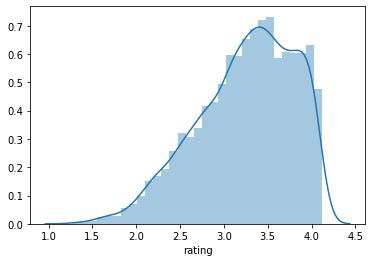

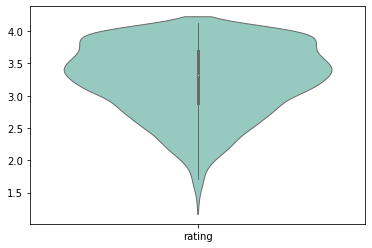

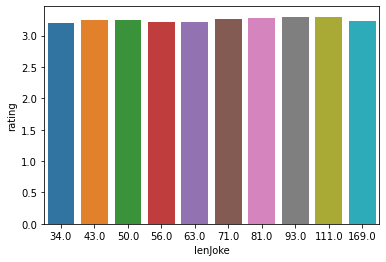

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 14 16:16:20 2020

@author: Ga
"""

import report
import graphs
import textMining

print("Watcha wanna see?")
print("-----------------")

while(True):
    action = input("Input -mining-, -report-, -graphs- or -exit- to end : ")
    if(action == "mining"):
        textMining.executeMining()
        continue
    elif(action == "report"):
        report.executeReport()
        continue
    elif(action == "graphs"):
        graphs.executeGraphs()
        continue
    elif(action == "exit"):
        while(True):
            exitProg = input("Exit? y/n \n")
            if(exitProg == "y"):
                print("Exiting program")
                sys.exit(0)
            elif(exitProg == "n"):
                break
    else:
        print("Try again : ")
        continue